# Answering questions with knowledge graph vs text-based context in ChatGPT
- Updated 2 Apr 2024 to adapt to newer version of OpenAI API
- Companion Notebook to https://www.youtube.com/watch?v=1RZ5yIyz31c

- Key findings
    - If knowledge graph is extracted correctly, it will actually be better than using the whole context as it can help to extract out only the relevant bits
    - However, if the knowledge graph is extracted wrongly, it can lose information, so we must ensure the knowledge graph extraction is done with the right schema
    - Knowledge graph-based answering will never be truly general, as the schema will constrain the triplets formed. For truly general QA, it is best to use the whole context
    
- Uses StrictJSON to parse the Knowledge Graph: https://github.com/tanchongmin/strictjson

# Import required packages

In [1]:
# !pip install strictjson

In [2]:
from strictjson import *
import os
import openai
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Put your OpenAI API key here
os.environ["OPENAI_API_KEY"] = '<YOUR KEY HERE>'

# Utility functions

In [4]:
def chat(system_prompt, user_prompt = '', model = 'gpt-3.5-turbo', temperature = 0, **kwargs):
    ''' This replies the user based on a system prompt and user prompt to call OpenAI Chat Completions API '''
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        temperature = temperature,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        **kwargs
    )
    res = response.choices[0].message.content
    return res

In [5]:
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in kg)

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

# Context
- We create a fictional story and get GPT to answer a question about it
- Here, the correct answer should be 2025

In [6]:
context ='''Apple announced the MacNCheese Pro in 2025. It proved a big hit.
Apple gave Cheese a rousing ovation in 2026 after he invented the MacNCheese Pro in 2024.
Orange created a competing product called the OrangeNCheese Pro.
It's price was slightly higher at $5000, compared to Apple's $4000.'''

question = 'When was the MacNCheese Pro announced?'

# Approach 1: Without Knowledge Graph and Context
- This does not fare too well are the story is fictional and there is no knowledge of this in Native GPT

In [7]:
# There is no knowledge of the MacNCheese Pro in native GPT
print('Question:', question)
print('Answer without Knowledge Graph and Context:', chat(question))

Question: When was the MacNCheese Pro announced?
Answer without Knowledge Graph and Context: The MacNCheese Pro was announced on April 1, 2022.


# Approach 2: Using only Context
- This is actually good enough and can be sufficient if the right part of the context is provided

In [8]:
print('Question:', question)
print('Answer with Context:', chat(f"Context: {context}\nQuestion: {question}"))

Question: When was the MacNCheese Pro announced?
Answer with Context: The MacNCheese Pro was announced in 2025.


# Approach 3: Using Knowledge Graph

## Step 1: Generate knowledge graph from context

In [9]:
res = strict_json(system_prompt = '''You are a knowledge graph builder. 
You are to output relations between two objects in the form (object_1, relation, object_2). 
All information about dates must be included.
Example Input: John bought a laptop
Example Output: [('John', 'bought', 'laptop')]
Example Input: John built a house in 2019
Example Output: [('John', 'built', 'house'), ('house', 'built in', '2019')]''',
                    user_prompt = context,
                    output_format = {"List of triplets": "List of triplets of the form (object_1, relation, object_2), type: list"})
print(res)

{'List of triplets': [('Apple', 'announced', 'MacNCheese Pro'), ('MacNCheese Pro', 'announced in', '2025'), ('Apple', 'gave', 'Cheese'), ('Cheese', 'invented', 'MacNCheese Pro'), ('MacNCheese Pro', 'invented in', '2024'), ('Apple', 'ovation', 'Cheese'), ('Cheese', 'ovation in', '2026'), ('Orange', 'created', 'OrangeNCheese Pro'), ('OrangeNCheese Pro', 'competing product with', 'MacNCheese Pro'), ('OrangeNCheese Pro', 'price', '$5000'), ('Apple', 'price', '$4000')]}


In [10]:
kg = res['List of triplets']

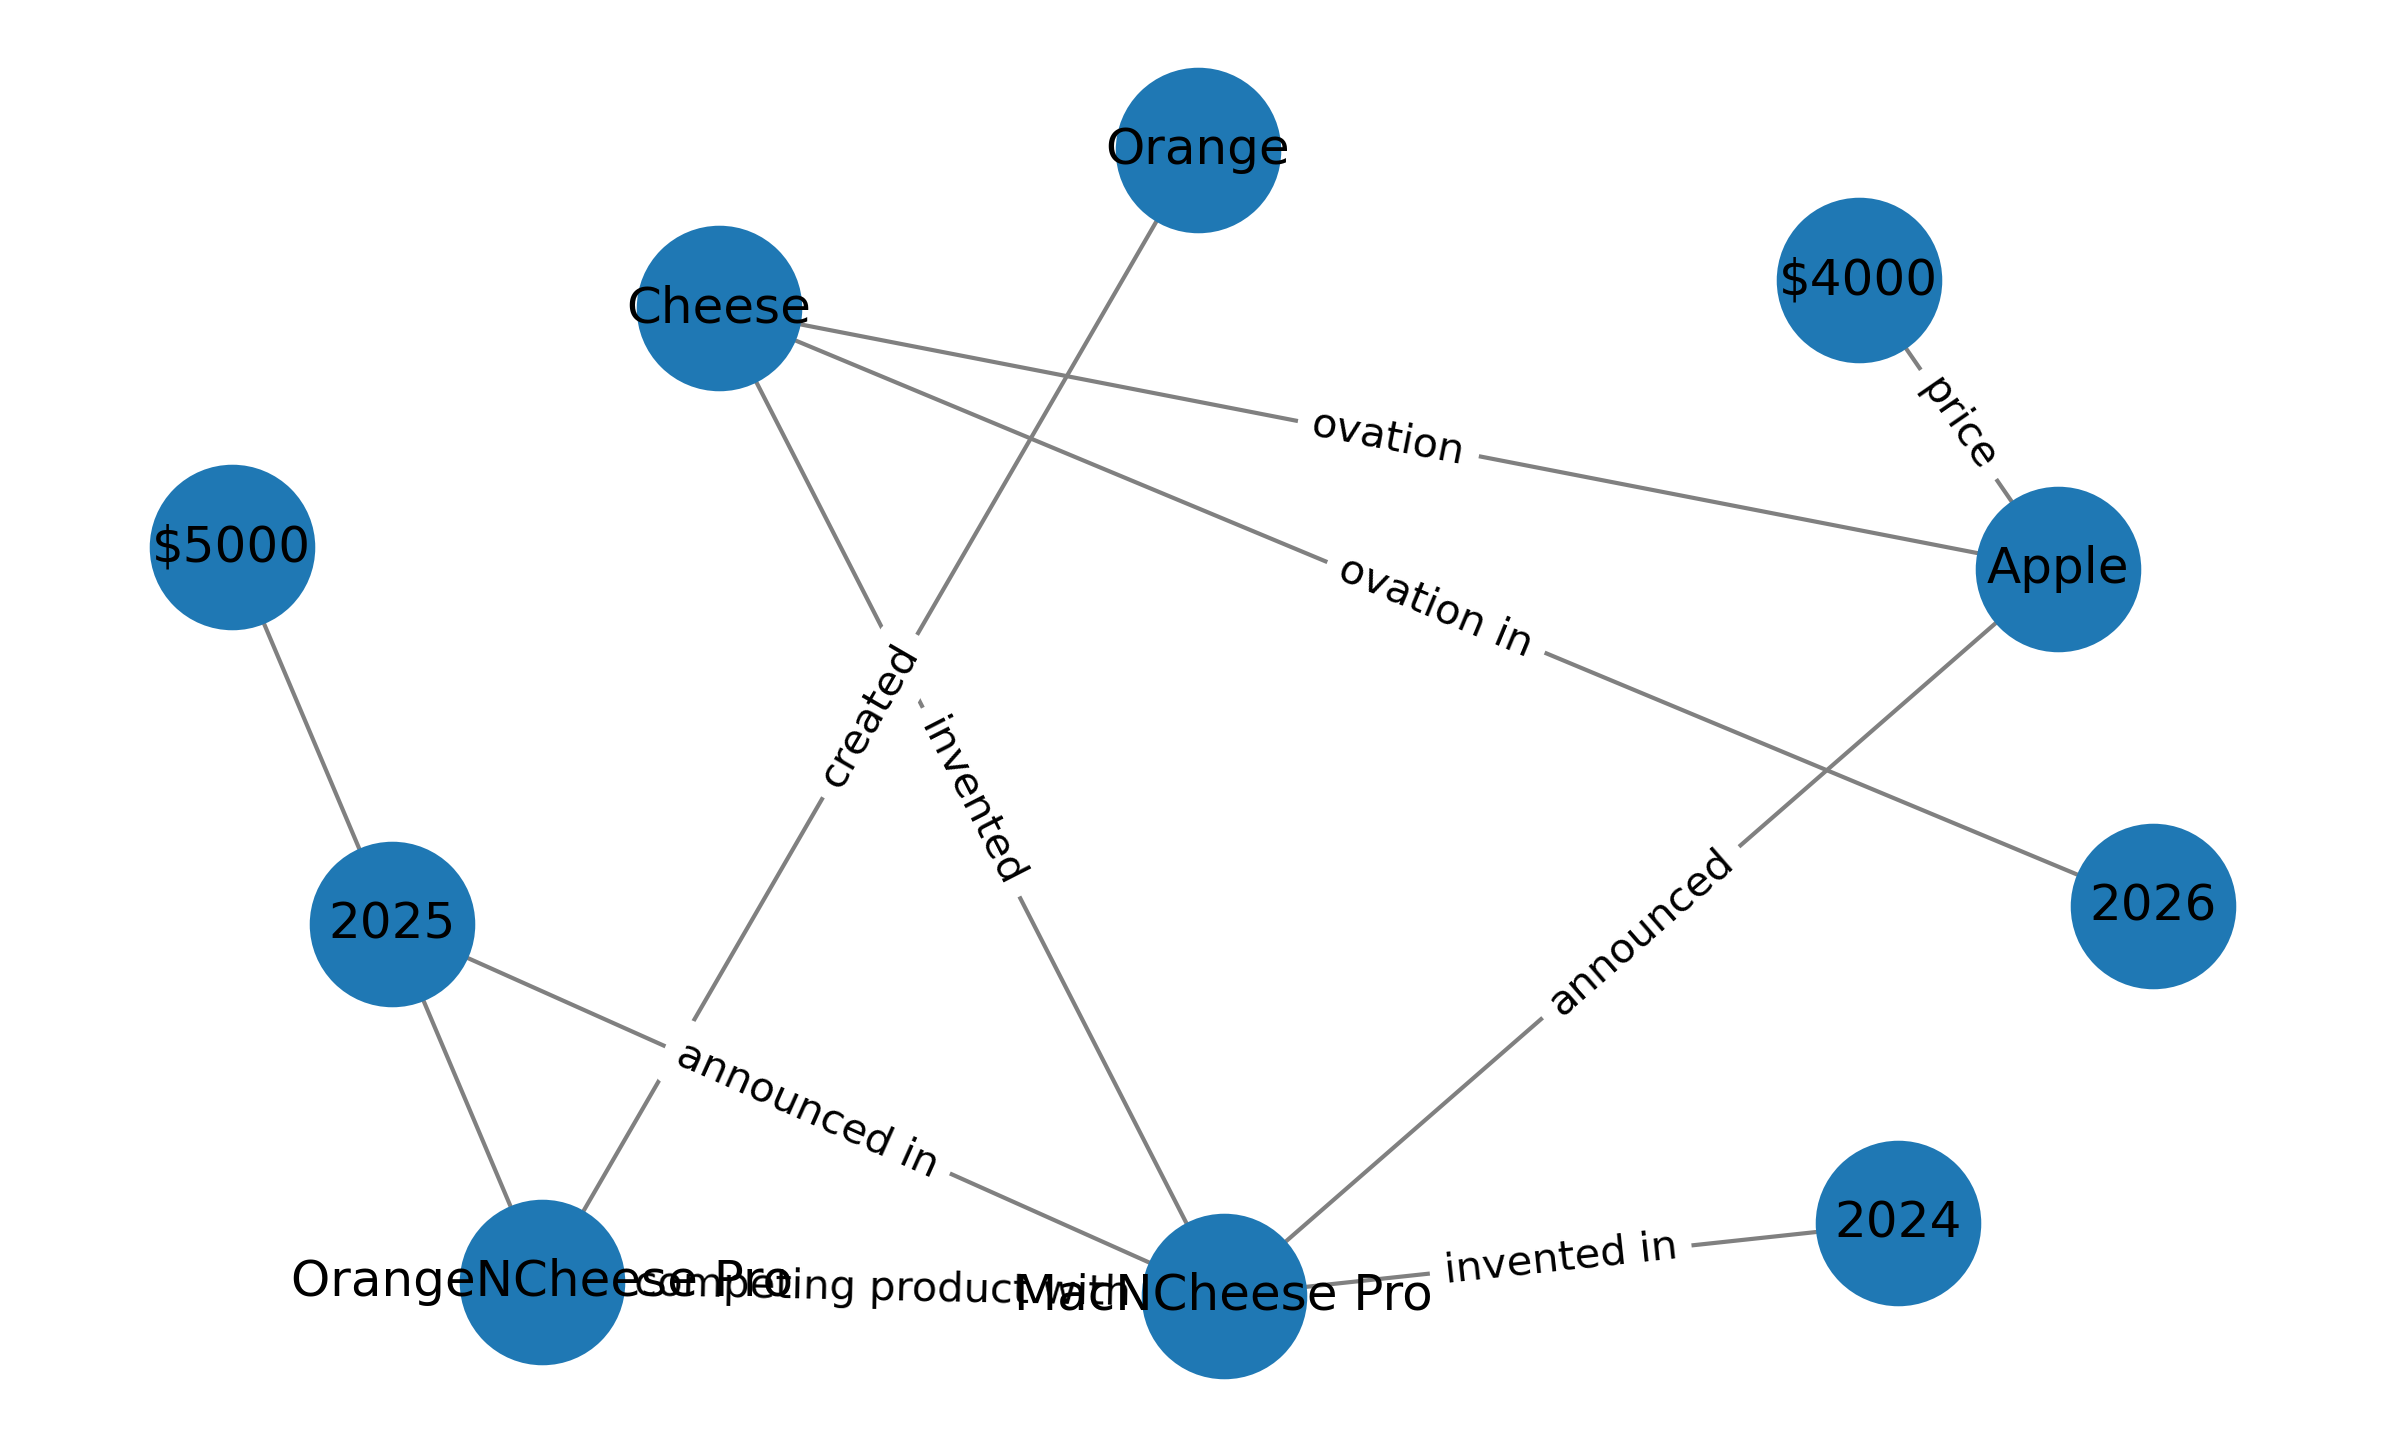

In [11]:
plot_graph(kg)

# Step 2: Parse Knowledge Graph
- Retrieve only triplets that are relevant to the question by using GPT to parse through
- Can also do by cosine similarity, or entity matching, though performance may be worse off

In [12]:
res = strict_output(system_prompt = f'''You are a knowledge graph parser. 
Only output the triplets that are relevant to the question.
Knowledge Graph: {kg}''',
                    user_prompt = f'''Question: {question}''',
                    output_format = {"Parsed Knowledge Graph": "List of triplets of the form (object1, relation, object2), type: list"})
print(res)

{'Parsed Knowledge Graph': [('MacNCheese Pro', 'announced in', '2025')]}


In [13]:
parsed_kg = res['Parsed Knowledge Graph']

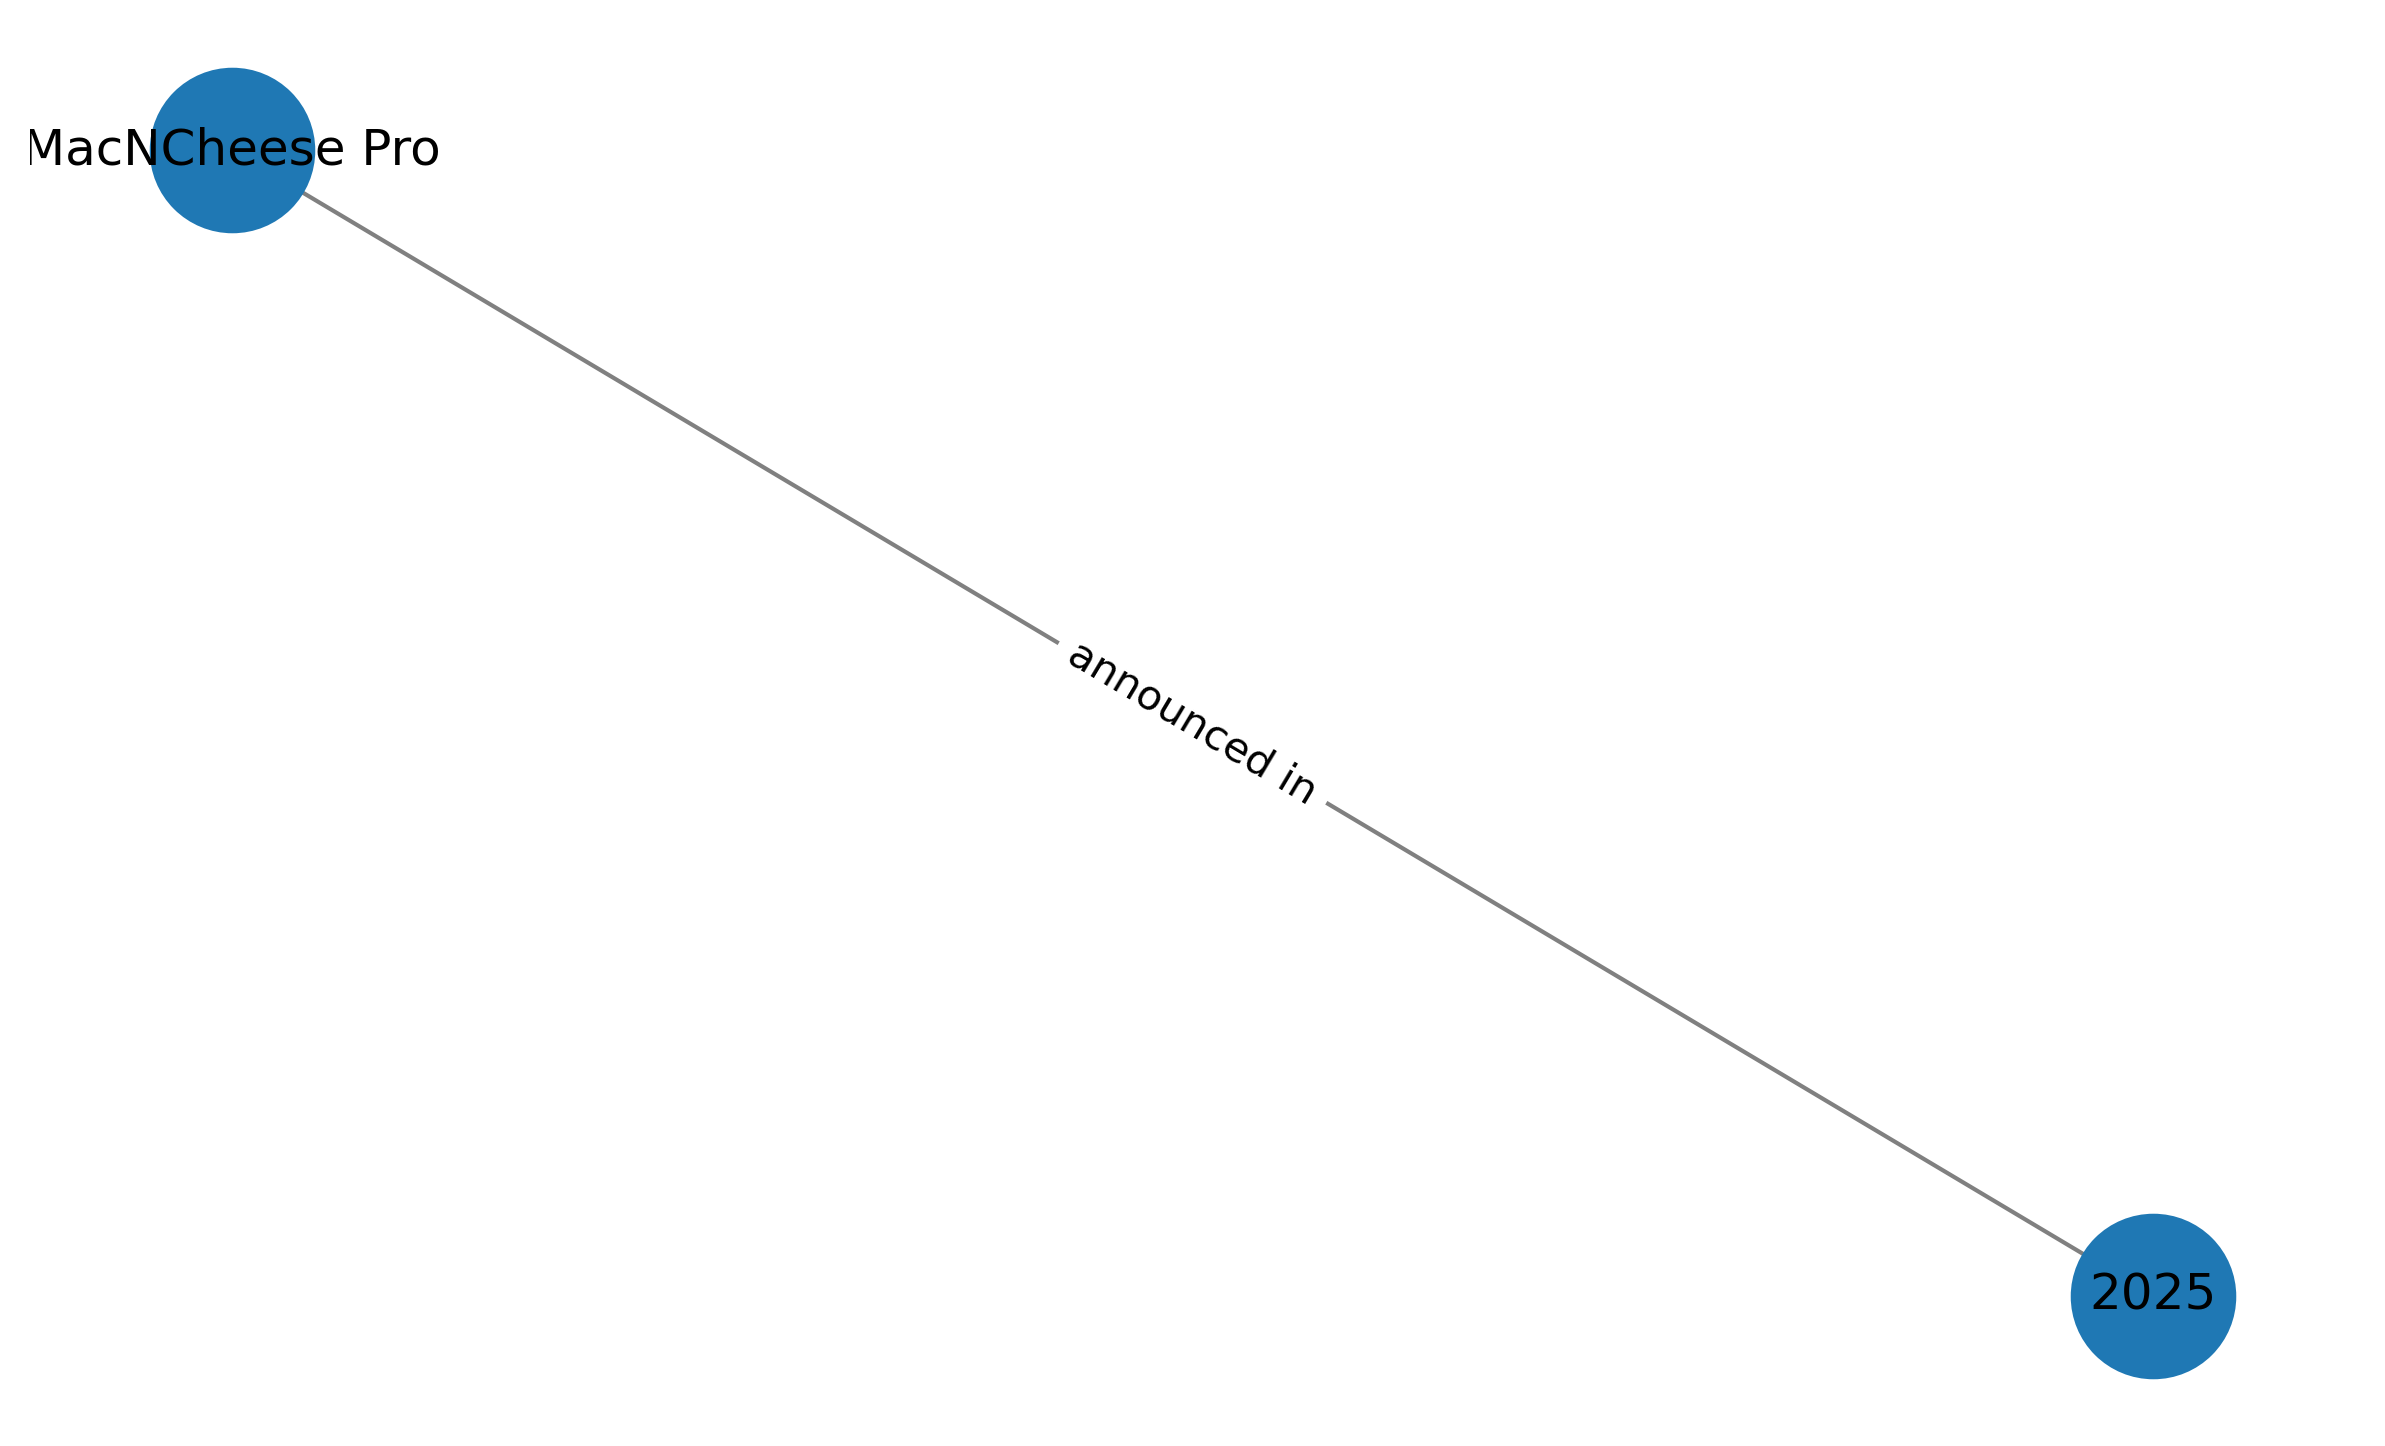

In [14]:
plot_graph(parsed_kg)

# Step 3: Use Parsed Knowledge Graph to Answer Question

In [15]:
res = strict_json(system_prompt = f'''Use the knowledge graph to answer the following question. 
If you are unsure, output 'No Info'
Knowledge Graph: {parsed_kg}''',
                    user_prompt = f'''Question: {question}''',
                    output_format = {"Answer": "Answer question using knowledge graph"})
print('Question:', question)
print('Answer with Parsed Knowledge Graph:', res['Answer'])

Question: When was the MacNCheese Pro announced?
Answer with Parsed Knowledge Graph: 2025
